In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<IPython.core.display.Javascript object>

In [3]:
from protein_conformal.util import *

<IPython.core.display.Javascript object>

In [4]:
# query_embeddings = np.load('/data/ron/protein-conformal/data/gene_unknown/all_aa_seqs.npy')
query_embeddings = np.load('/data/ron/protein-conformal/data/gene_unknown/unknown_aa_seqs.npy')

<IPython.core.display.Javascript object>

In [5]:
query_embeddings.shape

(149, 512)

<IPython.core.display.Javascript object>

In [50]:
# query_fastas, query_metadata = read_fasta('/data/ron/protein-conformal/data/gene_unknown/all_aa_seqs.fasta')
query_fastas, query_metadata = read_fasta('/data/ron/protein-conformal/data/gene_unknown/unknown_aa_seqs.fasta')

<IPython.core.display.Javascript object>

In [7]:
embeddings = np.load('/data/ron/protein-vec/src_run/protein_vec_embeddings/lookup_embeddings.npy')
lookup_proteins_meta = pd.read_csv('/data/ron/protein-vec/src_run/protein_vec_embeddings/lookup_embeddings_meta_data.tsv', sep="\t")

<IPython.core.display.Javascript object>

In [8]:
column = 'Pfam'
col_lookup = lookup_proteins_meta[~lookup_proteins_meta[column].isnull()]
col_lookup_embeddings = embeddings[col_lookup.index]
col_meta_data = col_lookup[column].values

# load database
lookup_database = load_database(col_lookup_embeddings)

<IPython.core.display.Javascript object>

In [9]:
# Query for the 1st nearest neighbor
k = 10
D, I = query(lookup_database, query_embeddings, k)

<IPython.core.display.Javascript object>

In [10]:
D_max = np.max(D, axis=1)

<IPython.core.display.Javascript object>

In [11]:
fdr = np.load('/data/ron/protein-conformal/data/pfam_fdr_2024-06-25.npy', allow_pickle=True)

<IPython.core.display.Javascript object>

In [12]:
fdr = fdr.item()

<IPython.core.display.Javascript object>

In [13]:
fdr.keys()

dict_keys(['risks', 'tprs', 'lhats', 'fdr_cals'])

<IPython.core.display.Javascript object>

In [ ]:
np.mean(fdr['lhats'])

In [73]:
# l_hat = 0.999980225003127 # mean result
l_hat = np.mean(fdr['lhats'])

<IPython.core.display.Javascript object>

In [74]:
(D_max > l_hat).sum()

59

<IPython.core.display.Javascript object>

In [38]:
filtered_I = I[D_max > l_hat]

<IPython.core.display.Javascript object>

In [39]:
first_entries = filtered_I[:, 0]

<IPython.core.display.Javascript object>

In [62]:
df_hits = col_lookup.iloc[first_entries].drop(columns='Unnamed: 0').reset_index(drop=True)
df_hits['query sequence'] = np.array(query_fastas)[D_max > l_hat]
df_hits['query_name'] = np.array(query_metadata)[D_max > l_hat]
# Define the columns you want to appear first
first_columns = ['query_name', 'query sequence']

# Get the remaining columns excluding the ones you want first
remaining_columns = [col for col in df_hits.columns if col not in first_columns]

# Combine the lists to get the new column order
new_column_order = first_columns + remaining_columns

# Reindex the DataFrame with the new column order
df_hits = df_hits[new_column_order]

<IPython.core.display.Javascript object>

In [66]:
# from Bio import pairwise2
# from Bio.pairwise2 import format_alignment
from Bio.Align import PairwiseAligner


<IPython.core.display.Javascript object>

In [67]:
# Define the sequence identity function using Bio.Align.PairwiseAligner
def seq_identity(seq1, seq2):
    """
    Calculate the sequence identity between two sequences using pairwise alignment.
    
    Parameters:
    seq1 (str): First sequence
    seq2 (str): Second sequence
    
    Returns:
    float: Sequence identity percentage
    """
    aligner = PairwiseAligner()
    alignments = aligner.align(seq1, seq2)
    best_alignment = alignments[0]
    seq1_aligned, seq2_aligned = best_alignment.aligned
    
    # Calculate identity
    matches = sum(a == b for a, b in zip(seq1, seq2) if a == b)
    length = max(len(seq1), len(seq2))
    return matches / length * 100

<IPython.core.display.Javascript object>

In [68]:
df_hits['seq_identity'] = df_hits.apply(lambda x: seq_identity(x['query sequence'], x['Sequence']), axis=1)

<IPython.core.display.Javascript object>

<AxesSubplot:>

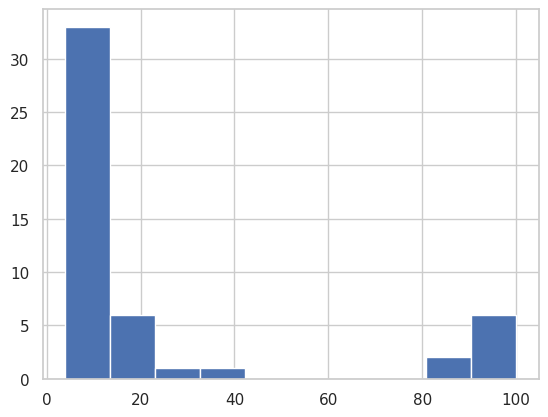

<IPython.core.display.Javascript object>

In [71]:
df_hits['seq_identity'].hist()

In [70]:
df_hits.head()

query_name                                     query sequence  \
0  >MMSYN1_0411 1=Unknown  MQIPIIKPKKAPPLTIEEINEIKQHSSYEKSYLKTFNKYKKKVEHR...   
1  >MMSYN1_0433 1=Unknown  MFLEVIAKDLSDIRVINNSKADRIEFCKNLEVGGLTPSLDEIILAN...   
2  >MMSYN1_0109 2=Generic  MNKVLLGCHVSMNKQNNYLVGSVNEAISYKANTFMIFTGPPQSTLR...   
3  >MMSYN1_0097 2=Generic  MITNETKPILLIDGYHLLHKGYYGTLKRTIVSKNKDGIVINAIYSF...   
4  >MMSYN1_0063 2=Generic  MKIRDIQIDGKVVQGPMAGVSNEAFRIISKQHGASLVYAEMVSVAG...   

    Entry  Reviewed  Entry Name  \
0  P75134  reviewed  Y657_MYCPN   
1  B0URL9  reviewed  CUTC_HISS2   
2  Q2ST57  reviewed  END4_MYCCT   
3  Q9KAV6  reviewed  EX53_HALH5   
4  Q1RH84  reviewed   DUS_RICBR   

                                       Protein names  \
0              Uncharacterized protein MG443 homolog   
1                        PF03932 family protein CutC   
2  Probable endonuclease 4 (EC 3.1.21.2) (Endodeo...   
3                    5'-3' exonuclease (EC 3.1.11.-)   
4  Probable tRNA-dihydrouridine synthase (EC 1.3....   

                 Gene Names  \
0  MPN_657 K05_orf401 MP185   
1             cutC HSM_0457   
2             nfo MCAP_0060   
3                    BH2180   
4              dus RBE_1199   

                                            Organism  Length  \
0  Mycoplasma pneumoniae (strain ATCC 29342 / M12...     401   
1  Histophilus somni (strain 2336) (Haemophilus s...     243   
2  Mycoplasma capricolum subsp. capricolum (strai...     289   
3  Halalkalibacterium halodurans (strain ATCC BAA...     303   
4                Rickettsia bellii (strain RML369-C)     326   

                  Gene Ontology (biological process)  \
0                                                NaN   
1                                                NaN   
2                            DNA repair [GO:0006281]   
3  DNA replication, Okazaki fragment processing [...   
4                                                NaN   

  Gene Ontology (cellular component)  \
0       plasma membrane [GO:0005886]   
1             cytoplasm [GO:0005737]   
2                                NaN   
3                                NaN   
4                                NaN   

                  Gene Ontology (molecular function)  \
0                                                NaN   
1                                                NaN   
2  deoxyribonuclease IV (phage-T4-induced) activi...   
3  5'-flap endonuclease activity [GO:0017108]; DN...   
4  flavin adenine dinucleotide binding [GO:005066...   

                                  Gene Ontology (GO) EC number  \
0                       plasma membrane [GO:0005886]       NaN   
1                             cytoplasm [GO:0005737]       NaN   
2  deoxyribonuclease IV (phage-T4-induced) activi...  3.1.21.2   
3  5'-flap endonuclease activity [GO:0017108]; DN...  3.1.11.-   
4  flavin adenine dinucleotide binding [GO:005066...   1.3.1.-   

                                            Sequence Date of creation  \
0  MDWLKRWFTRKDQDKTETTSASKRAKITSSLLMFSALYEAKKPLKY...       1997-11-01   
1  MDIEICIDNIESALIAQNSGADRLEVCGCLALGGVTPPYSLIKTVL...       2008-05-20   
2  MDKVLLGCHVSMNKQNNYLVGSVNEAISYKANTFMIFTGPPQSTLR...       2008-01-15   
3  MHSPVLLLIDGFNLLSRGYFATSYGKDEAQLPRNEAGYYINALRVF...       2001-11-16   
4  MIKIGNIELSSNIILAPMSGVTDLEFRRLVKRFGAGLVVSEMIASR...       2007-03-20   

                      Gene3D              Pfam  seq_identity  
0               3.30.70.120;  PF10035;PF02588;      6.547619  
1               3.20.20.380;          PF03932;     15.637860  
2               3.20.20.150;          PF01261;     96.193772  
3  1.10.150.20;3.40.50.1010;  PF01367;PF02739;     15.181518  
4                3.20.20.70;          PF01207;     28.220859

<IPython.core.display.Javascript object>

In [ ]:
df_hits.to_csv('/data/ron/protein-conformal/data/gene_unknown/unknown_aa_seqs_pfam_hits.csv', index=False)

<IPython.core.display.Javascript object>

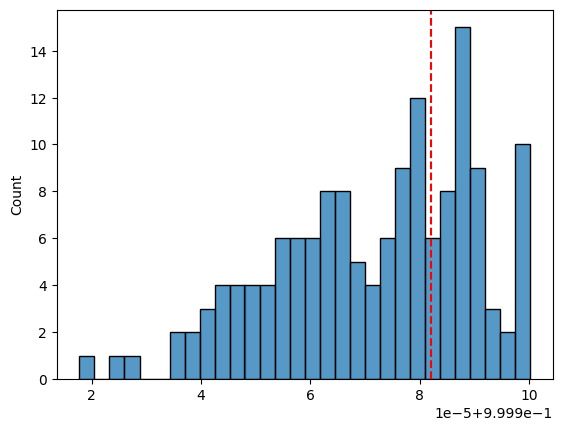

<IPython.core.display.Javascript object>

In [17]:
# sns.distplot(D_max)
# sns.displot(D_max)
sns.histplot(D_max, bins=30)
plt.axvline(l_hat, color='r', linestyle='--')


In [75]:
# Determine the counts
total_count = len(D_max)
hits_count = np.sum(D_max >= l_hat)
no_hits_count = np.sum(D_max < l_hat)

<IPython.core.display.Javascript object>

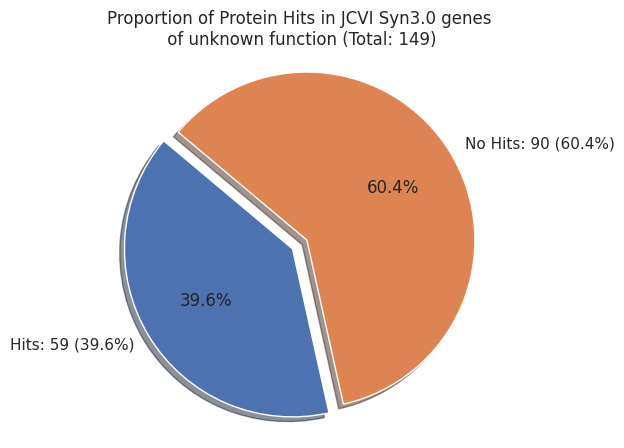

<IPython.core.display.Javascript object>

In [76]:
# Set the style to a Seaborn style
sns.set_theme(style="whitegrid")
# Create the pie chart
labels = [
    f'Hits: {hits_count} ({hits_count / total_count * 100:.1f}%)',
    f'No Hits: {no_hits_count} ({no_hits_count / total_count * 100:.1f}%)'
]
sizes = [hits_count, no_hits_count]
colors = sns.color_palette()[0:2]  # Use Seaborn's color palette
explode = (0.1, 0)  # only "explode" the 1st slice (Hits)

plt.figure(figsize=(5, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f'Proportion of Protein Hits in JCVI Syn3.0 genes\n of unknown function (Total: {total_count})')
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/protein_hits_pie.pdf', bbox_inches='tight')